In [2]:
import sys
import os
import argparse
import time
import pandas as pd
import numpy as np
import seaborn as sns

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

ModuleNotFoundError: No module named 'torch'

In [ ]:
year = 2019
ticker = 'IFM'

# cd = os.path.dirname(__file__)
df = pd.read_csv(os.path.join(f'data/index/{year}/{ticker}.csv'), index_col=0, encoding='gbk')
df['type'] = df.index
df['time'] = pd.to_datetime(df['时间'])
df['open'] = df['开']
df['close'] = df['收']
df['high'] = df['高']
df['low'] = df['低']
df['volume'] = df['成交量']
df = df.set_index('time')
df = df[['time', 'open', 'close', 'high', 'low', 'volume']]
# df = df.iloc[:2000]

In [3]:
df

,time,open,close,high,low,volume
0,2019-01-02 09:31:00,3012.4,3008.6,3013.2,3008.0,1021.0
1,2019-01-02 09:32:00,3008.6,3007.8,3009.2,3006.8,503.0
2,2019-01-02 09:33:00,3007.6,3010.2,3010.8,3007.4,363.0
3,2019-01-02 09:34:00,3010.4,3004.2,3010.8,3003.6,554.0
4,2019-01-02 09:35:00,3004.2,3003.6,3006.0,3003.2,326.0
...,...,...,...,...,...,...
58555,2019-12-31 14:56:00,4108.6,4109.4,4109.4,4108.0,356.0
58556,2019-12-31 14:57:00,4109.2,4106.6,4109.4,4106.4,411.0
58557,2019-12-31 14:58:00,4106.6,4109.6,4109.6,4106.0,547.0
58558,2019-12-31 14:59:00,4109.0,4109.0,4109.4,4108.0,659.0


In [4]:
df['ma5'] = df.close.ewm(halflife=5).mean()
df['ma20'] = df.close.ewm(halflife=25).mean()
macd_fast = df['ma5'] - df['ma20']
macd_slow = macd_fast.ewm(halflife=9).mean()
df['macd'] = macd_fast - macd_slow

vwap_window = 20
df['pv'] = df.close * df.volume
pv_sum = df['pv'].rolling(vwap_window).sum()
v_sum = df['volume'].rolling(vwap_window).sum()
df['vwap'] = pv_sum/v_sum

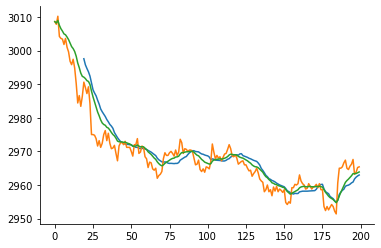

In [5]:
df.iloc[:200].vwap.plot()
df.iloc[:200].close.plot()
df.iloc[:200].ma5.plot()
sns.despine()

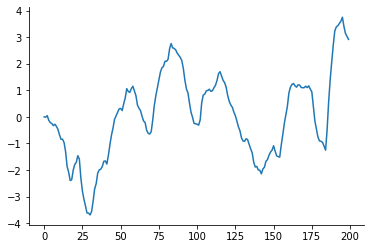

In [6]:
df.iloc[:200].macd.plot()
sns.despine()

In [7]:
trend_window = 3
df['macd_trend'] = (df.macd - df.macd.shift(trend_window))/trend_window

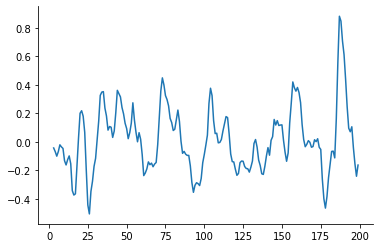

In [8]:
df.iloc[:200].macd_trend.plot()
sns.despine()

In [9]:
df['ma5_trend'] = (df.ma5 - df.ma5.shift(trend_window))/trend_window
df['ma20_trend'] = (df.ma20 - df.ma20.shift(trend_window))/trend_window

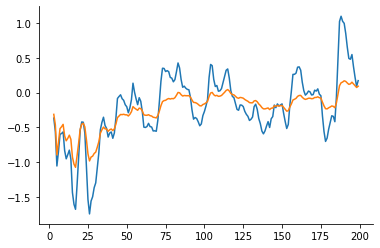

In [10]:
df.iloc[:200].ma5_trend.plot()
df.iloc[:200].ma20_trend.plot()
sns.despine()

In [11]:
h = 30
df[f'ret{h}'] = df.close.shift(-h)/df.close - 1
df[f'max_up{h}'] = df.iloc[::-1].close.rolling(h).max()/df.close - 1
df[f'max_down{h}'] = df.iloc[::-1].close.rolling(h).min()/df.close - 1

In [12]:
df['ret30'].describe()

count    58530.000000
mean         0.000171
std          0.004188
min         -0.039763
25%         -0.001813
50%          0.000000
75%          0.002001
max          0.036077
Name: ret30, dtype: float64

In [13]:
df['y'] = 0
df.loc[(df[f'max_up{h}']<0.0005) & (df[f'ret{h}']<-0.002), 'y'] = -1
df.loc[(df[f'max_down{h}']>-0.0005) & (df[f'ret{h}']>0.002), 'y'] = 1

In [14]:
df.y.value_counts()

 0    43428
 1     7708
-1     7424
Name: y, dtype: int64

In [15]:
df.head()

,time,open,close,high,low,volume,ma5,ma20,macd,pv,vwap,macd_trend,ma5_trend,ma20_trend,ret30,max_up30,max_down30,y
0,2019-01-02 09:31:00,3012.4,3008.6,3013.2,3008.0,1021.0,3008.600000,3008.600000,0.000000,3071780.6,NaN,NaN,NaN,NaN,-0.012431,0.000532,-0.012298,0
1,2019-01-02 09:32:00,3008.6,3007.8,3009.2,3006.8,503.0,3008.172318,3008.194455,-0.010642,1512923.4,NaN,NaN,NaN,NaN,-0.011769,0.000798,-0.012168,0
2,2019-01-02 09:33:00,3007.6,3010.2,3010.8,3007.4,363.0,3008.943767,3008.881589,0.047201,1092702.6,NaN,NaN,NaN,NaN,-0.011694,0.000000,-0.012956,-1
3,2019-01-02 09:34:00,3010.4,3004.2,3010.8,3003.6,554.0,3007.501087,3007.662076,-0.126770,1664326.8,NaN,-0.042257,-0.366304,-0.312641,-0.009320,0.000000,-0.010985,-1
4,2019-01-02 09:35:00,3004.2,3003.6,3006.0,3003.2,326.0,3006.491100,3006.803998,-0.214045,979173.6,NaN,-0.067801,-0.560406,-0.463486,-0.010121,0.000000,-0.010787,-1


In [16]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import AdaBoostClassifier
df = df.dropna()
df = df.drop(df[df.y==0].sample(frac=.83).index)
X = df.drop(columns=['time', 'pv', 'ma5', 'ma20', f'ret{h}', f'max_up{h}', f'max_down{h}', 'y'])
y = df.y
split = int(0.4*df.shape[0])
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
clf = AdaBoostClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)

In [17]:
clf.score(X_test, y_test)

0.3295799688865842

In [18]:
clf.feature_importances_

array([0.04, 0.08, 0.07, 0.07, 0.04, 0.09, 0.38, 0.05, 0.04, 0.14])

In [19]:
X.columns

Index(['open', 'close', 'high', 'low', 'volume', 'macd', 'vwap', 'macd_trend',
       'ma5_trend', 'ma20_trend'],
      dtype='object')

In [20]:
df['yhat'] = 0
df.yhat.iloc[split:] = clf.predict(X_test)

In [21]:
df.iloc[split:,:].yhat.value_counts()

 1    5113
 0    4454
-1    3932
Name: yhat, dtype: int64

In [22]:
df.iloc[split:,:].y.value_counts()

 0    4662
 1    4421
-1    4416
Name: y, dtype: int64

In [24]:
df[(df.y==1)&(df.yhat==1)].shape

(1594, 19)